# VGGT Demo - 3D Visualization (Simplified)

This notebook demonstrates VGGT's 3D reconstruction capabilities with matplotlib visualization instead of interactive Viser viewer.

## Features
- Load VGGT model for 3D scene reconstruction
- Process images to generate depth maps and point clouds
- Apply confidence filtering for quality control
- Visualize 3D point clouds with matplotlib

In [1]:
# Configure matplotlib for high-resolution outputs
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

In [2]:
# Import required packages
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
from pathlib import Path
import glob
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("Basic imports successful")

Basic imports successful


In [3]:
# Import VGGT modules
try:
    from vggt.models.vggt import VGGT
    from vggt.utils.load_fn import load_and_preprocess_images_square
    from vggt.utils.geometry import unproject_depth_map_to_point_map
    print("VGGT imports successful")
except ImportError as e:
    print(f"VGGT import error: {e}")
    # Fallback to basic functionality if VGGT is not available
    raise

/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VGGT imports successful


In [4]:
# Set device and data type
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    try:
        dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
    except:
        dtype = torch.float16
else:
    dtype = torch.float32

print(f"Using device: {device}")
print(f"Using dtype: {dtype}")

Using device: cpu
Using dtype: torch.float32


In [5]:
# Load VGGT model with timeout handling
print("Loading VGGT model...")
try:
    # Use the alternative loading method from demo_colmap.py if from_pretrained fails
    try:
        model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
    except Exception as e:
        print(f"from_pretrained failed: {e}")
        print("Trying alternative loading method...")
        model = VGGT()
        _URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
        model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
        model = model.to(device)
    
    model.eval()
    print("Model loaded successfully!")
except Exception as e:
    print(f"Model loading failed: {e}")
    raise

Loading VGGT model...


Model loaded successfully!


In [6]:
# Find and load example images
examples_dir = "/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt/examples"
scene_dirs = [d for d in Path(examples_dir).iterdir() if d.is_dir()]

if not scene_dirs:
    raise ValueError(f"No scene directories found in {examples_dir}")

# Use the first available scene
scene_dir = scene_dirs[0]
images_dir = scene_dir / "images"

if not images_dir.exists():
    raise ValueError(f"No images directory found in {scene_dir}")

image_paths = list(images_dir.glob("*"))
image_paths = [p for p in image_paths if p.suffix.lower() in ['.jpg', '.jpeg', '.png']]

if len(image_paths) == 0:
    raise ValueError(f"No valid images found in {images_dir}")

print(f"Found {len(image_paths)} images in {scene_dir.name}")
print(f"Image paths: {[p.name for p in image_paths[:5]]}{'...' if len(image_paths) > 5 else ''}")

Found 8 images in room
Image paths: ['no_overlap_8.jpg', 'no_overlap_2.jpg', 'no_overlap_3.jpg', 'no_overlap_1.png', 'no_overlap_4.jpg']...


In [7]:
# Load and preprocess images
resolution = 518
image_path_strs = [str(p) for p in image_paths]

print(f"Loading {len(image_path_strs)} images...")
images, original_coords = load_and_preprocess_images_square(image_path_strs, resolution)
images = images.to(device)
print(f"Loaded images with shape: {images.shape}")

Loading 8 images...
Loaded images with shape: torch.Size([8, 3, 518, 518])


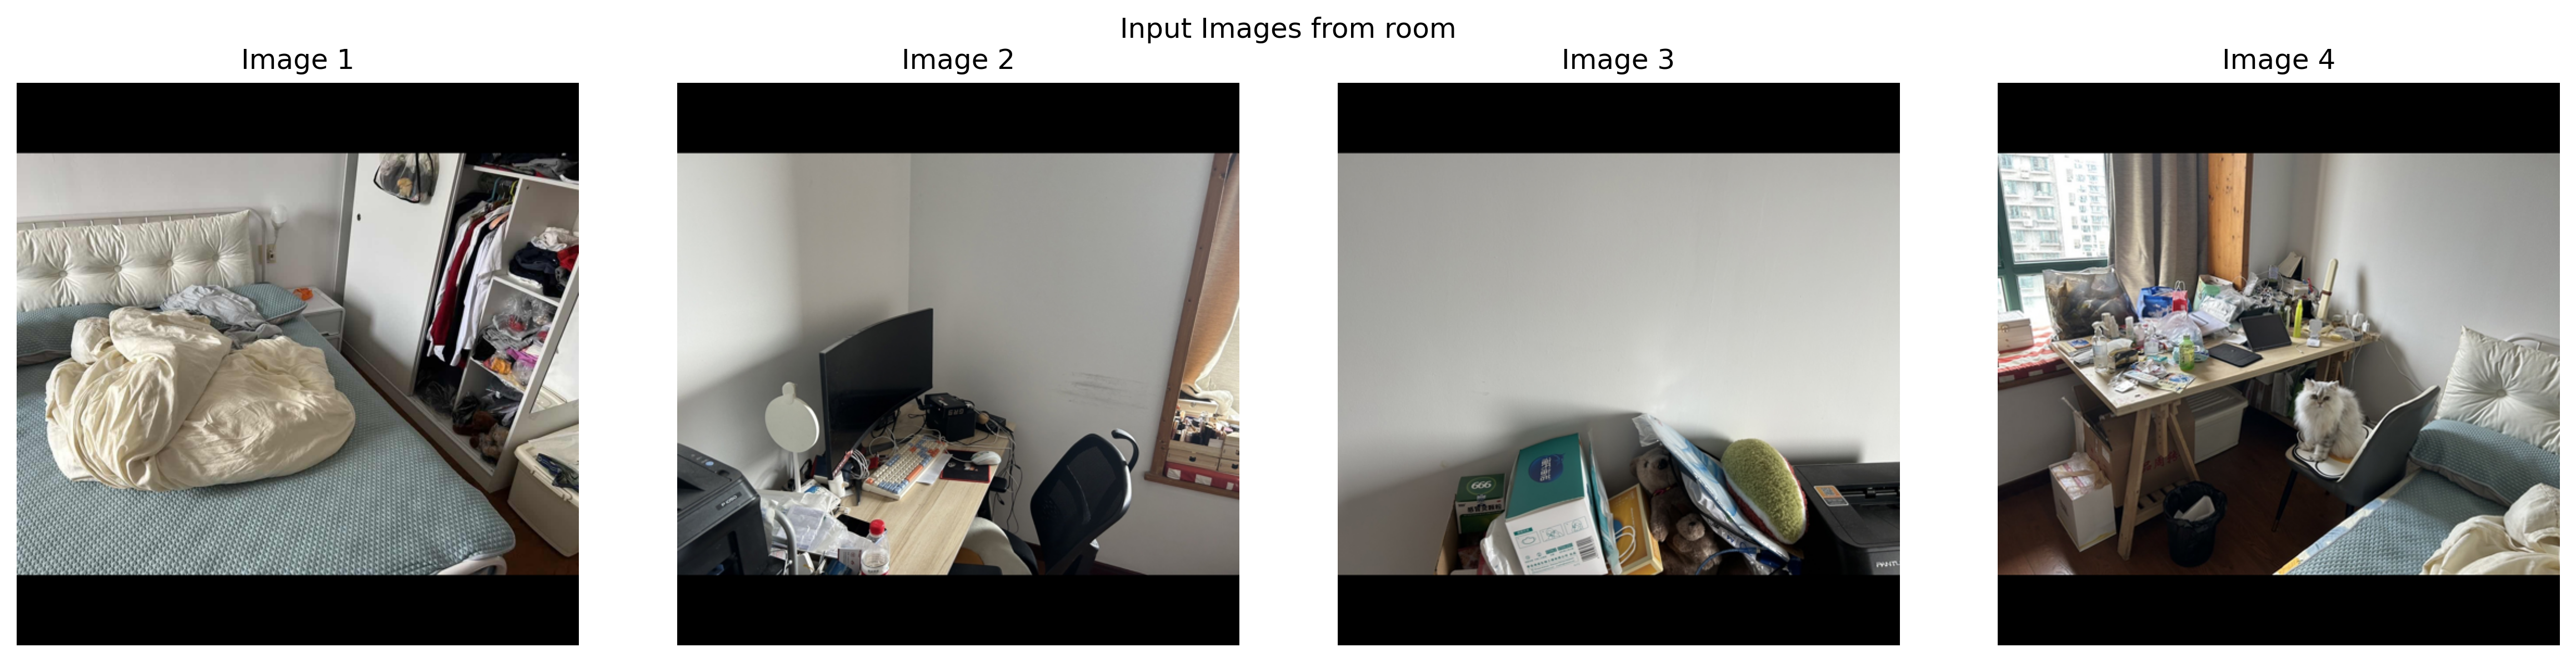

In [8]:
# Display input images
num_images = min(4, len(images))
fig, axes = plt.subplots(1, num_images, figsize=(16, 4))
if num_images == 1:
    axes = [axes]

for i in range(num_images):
    img_np = images[i].cpu().permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    axes[i].imshow(img_np)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.suptitle(f"Input Images from {scene_dir.name}")
plt.tight_layout()
plt.show()

In [9]:
# Run VGGT inference
print("Running VGGT inference...")
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype, enabled=(device == "cuda")):
        predictions = model(images)

print("Inference completed!")
print(f"Prediction keys: {list(predictions.keys())}")

Running VGGT inference...


/var/folders/7q/tx7m0tg12m5cgq7k8z8q2dzw0000gn/T/ipykernel_95213/1623081390.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype, enabled=(device == "cuda")):


/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt/vggt/models/vggt.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Inference completed!
Prediction keys: ['pose_enc', 'pose_enc_list', 'depth', 'depth_conf', 'world_points', 'world_points_conf', 'images']


In [10]:
# Extract predictions safely
print("Extracting predictions...")
for key, value in predictions.items():
    print(f"{key}: {value.shape if hasattr(value, 'shape') else type(value)}")

# Extract based on actual prediction keys
depth_maps = predictions['depth'].cpu().numpy()
confidence_maps = predictions['depth_conf'].cpu().numpy()
world_points = predictions['world_points'].cpu().numpy()
world_points_conf = predictions['world_points_conf'].cpu().numpy()

# Generate camera matrices from pose encoding
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
extrinsics, intrinsics = pose_encoding_to_extri_intri(predictions["pose_enc"], images.shape[-2:])
extrinsics = extrinsics.cpu().numpy()
intrinsics = intrinsics.cpu().numpy()

print(f"Depth maps shape: {depth_maps.shape}")
print(f"Confidence maps shape: {confidence_maps.shape}")
print(f"World points shape: {world_points.shape}")
print(f"World points conf shape: {world_points_conf.shape}")
print(f"Extrinsics shape: {extrinsics.shape}")
print(f"Intrinsics shape: {intrinsics.shape}")

Extracting predictions...
pose_enc: torch.Size([1, 8, 9])
pose_enc_list: <class 'list'>
depth: torch.Size([1, 8, 518, 518, 1])
depth_conf: torch.Size([1, 8, 518, 518])
world_points: torch.Size([1, 8, 518, 518, 3])
world_points_conf: torch.Size([1, 8, 518, 518])
images: torch.Size([1, 8, 3, 518, 518])
Depth maps shape: (1, 8, 518, 518, 1)
Confidence maps shape: (1, 8, 518, 518)
World points shape: (1, 8, 518, 518, 3)
World points conf shape: (1, 8, 518, 518)
Extrinsics shape: (1, 8, 3, 4)
Intrinsics shape: (1, 8, 3, 3)


In [11]:
# Generate 3D point clouds from VGGT world points
print("Using 3D world points from VGGT predictions...")
# Use the world_points directly from VGGT predictions
point_clouds = world_points.squeeze(0)  # Remove batch dimension
print(f"Point clouds shape: {point_clouds.shape}")

Using 3D world points from VGGT predictions...
Point clouds shape: (8, 518, 518, 3)


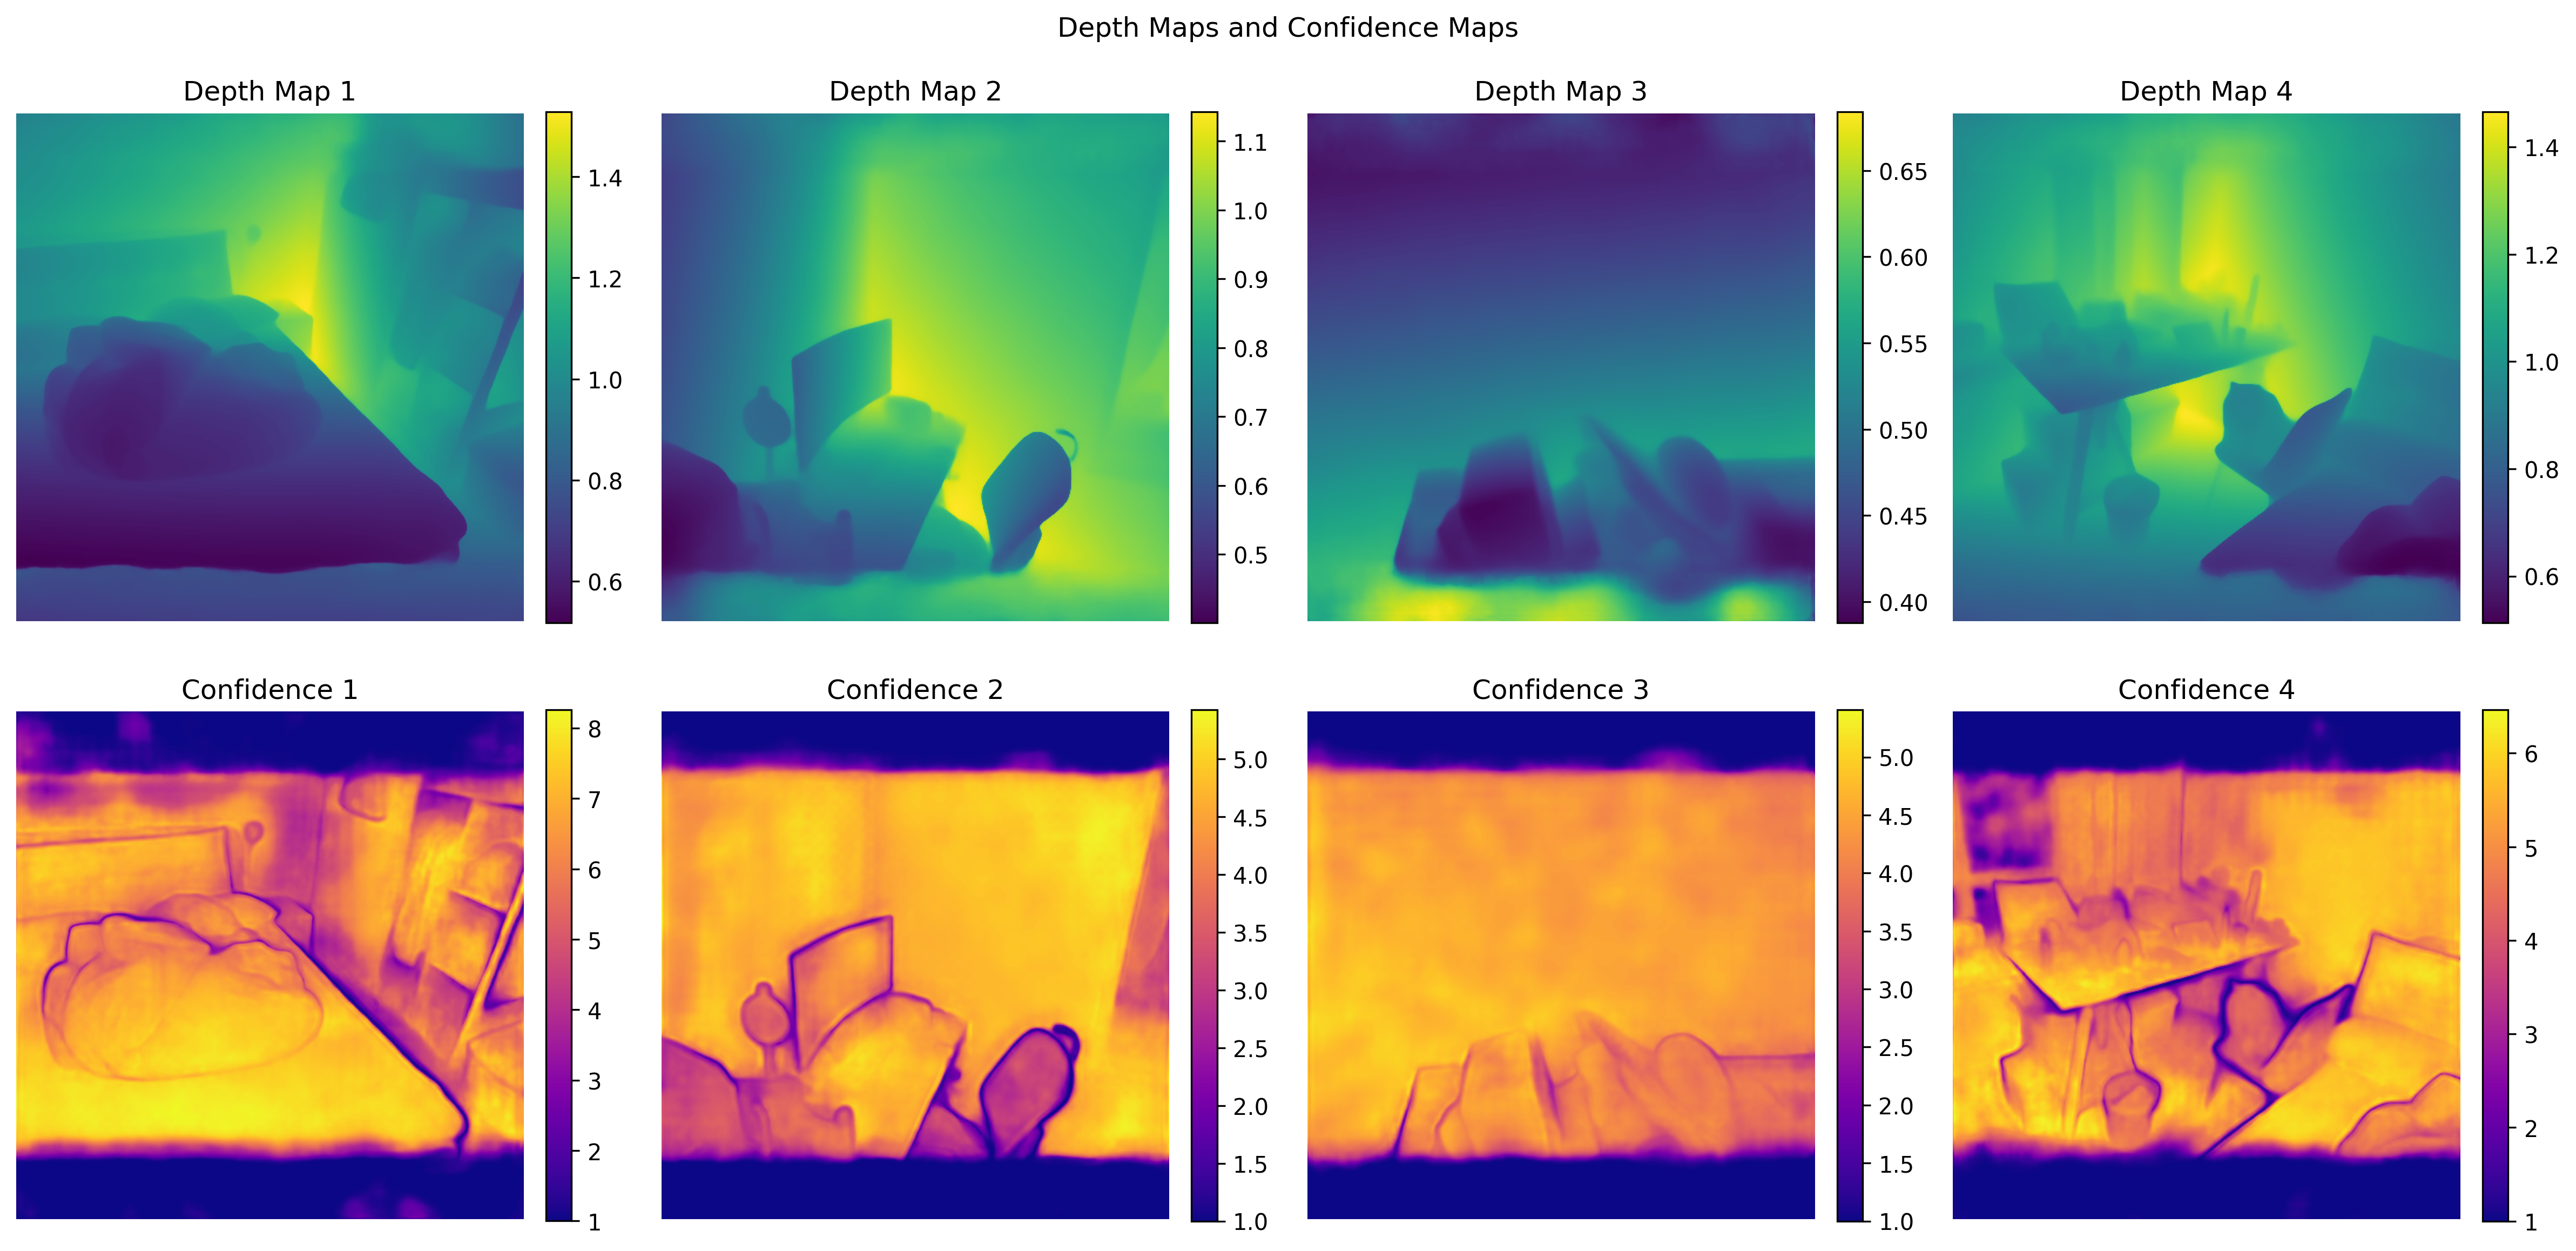

In [12]:
# Visualize depth maps
# Handle tensor shapes properly
depth_maps_viz = depth_maps.squeeze()
confidence_maps_viz = confidence_maps.squeeze()

if len(depth_maps_viz.shape) == 3:
    num_views = depth_maps_viz.shape[0]
else:
    # Single view case
    num_views = 1
    depth_maps_viz = depth_maps_viz[np.newaxis, ...]
    confidence_maps_viz = confidence_maps_viz[np.newaxis, ...]

num_views_display = min(4, num_views)
fig, axes = plt.subplots(2, num_views_display, figsize=(16, 8))
if num_views_display == 1:
    axes = axes.reshape(2, 1)

for i in range(num_views_display):
    # Depth map
    im1 = axes[0, i].imshow(depth_maps_viz[i], cmap='viridis')
    axes[0, i].set_title(f"Depth Map {i+1}")
    axes[0, i].axis('off')
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)
    
    # Confidence map
    im2 = axes[1, i].imshow(confidence_maps_viz[i], cmap='plasma')
    axes[1, i].set_title(f"Confidence {i+1}")
    axes[1, i].axis('off')
    plt.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.suptitle("Depth Maps and Confidence Maps")
plt.tight_layout()
plt.show()

In [13]:
# Apply confidence filtering
confidence_threshold = 0.5
print(f"Applying confidence filtering with threshold: {confidence_threshold}")

# Collect valid 3D points from all views
all_points = []
all_colors = []

# Handle the actual tensor shapes
num_views = point_clouds.shape[0]
for i in range(num_views):
    # Get confidence mask for this view
    conf_mask = world_points_conf.squeeze(0)[i] > confidence_threshold
    
    # Get valid 3D points for this view
    valid_points = point_clouds[i][conf_mask]
    
    # Get corresponding colors from original image
    img_rgb = images[i].cpu().permute(1, 2, 0).numpy()
    img_rgb = (img_rgb * 255).astype(np.uint8)
    valid_colors = img_rgb[conf_mask]
    
    all_points.append(valid_points)
    all_colors.append(valid_colors)
    
    print(f"View {i+1}: {len(valid_points)} valid points")

# Combine all points
if all_points:
    combined_points = np.concatenate(all_points, axis=0)
    combined_colors = np.concatenate(all_colors, axis=0)
    print(f"Total combined points: {len(combined_points)}")
else:
    print("No valid points found with current confidence threshold")
    # Set empty arrays for later use
    combined_points = np.array([])
    combined_colors = np.array([])

Applying confidence filtering with threshold: 0.5
View 1: 268324 valid points
View 2: 268324 valid points
View 3: 268324 valid points
View 4: 268324 valid points
View 5: 268324 valid points
View 6: 268324 valid points
View 7: 268324 valid points
View 8: 268324 valid points
Total combined points: 2146592


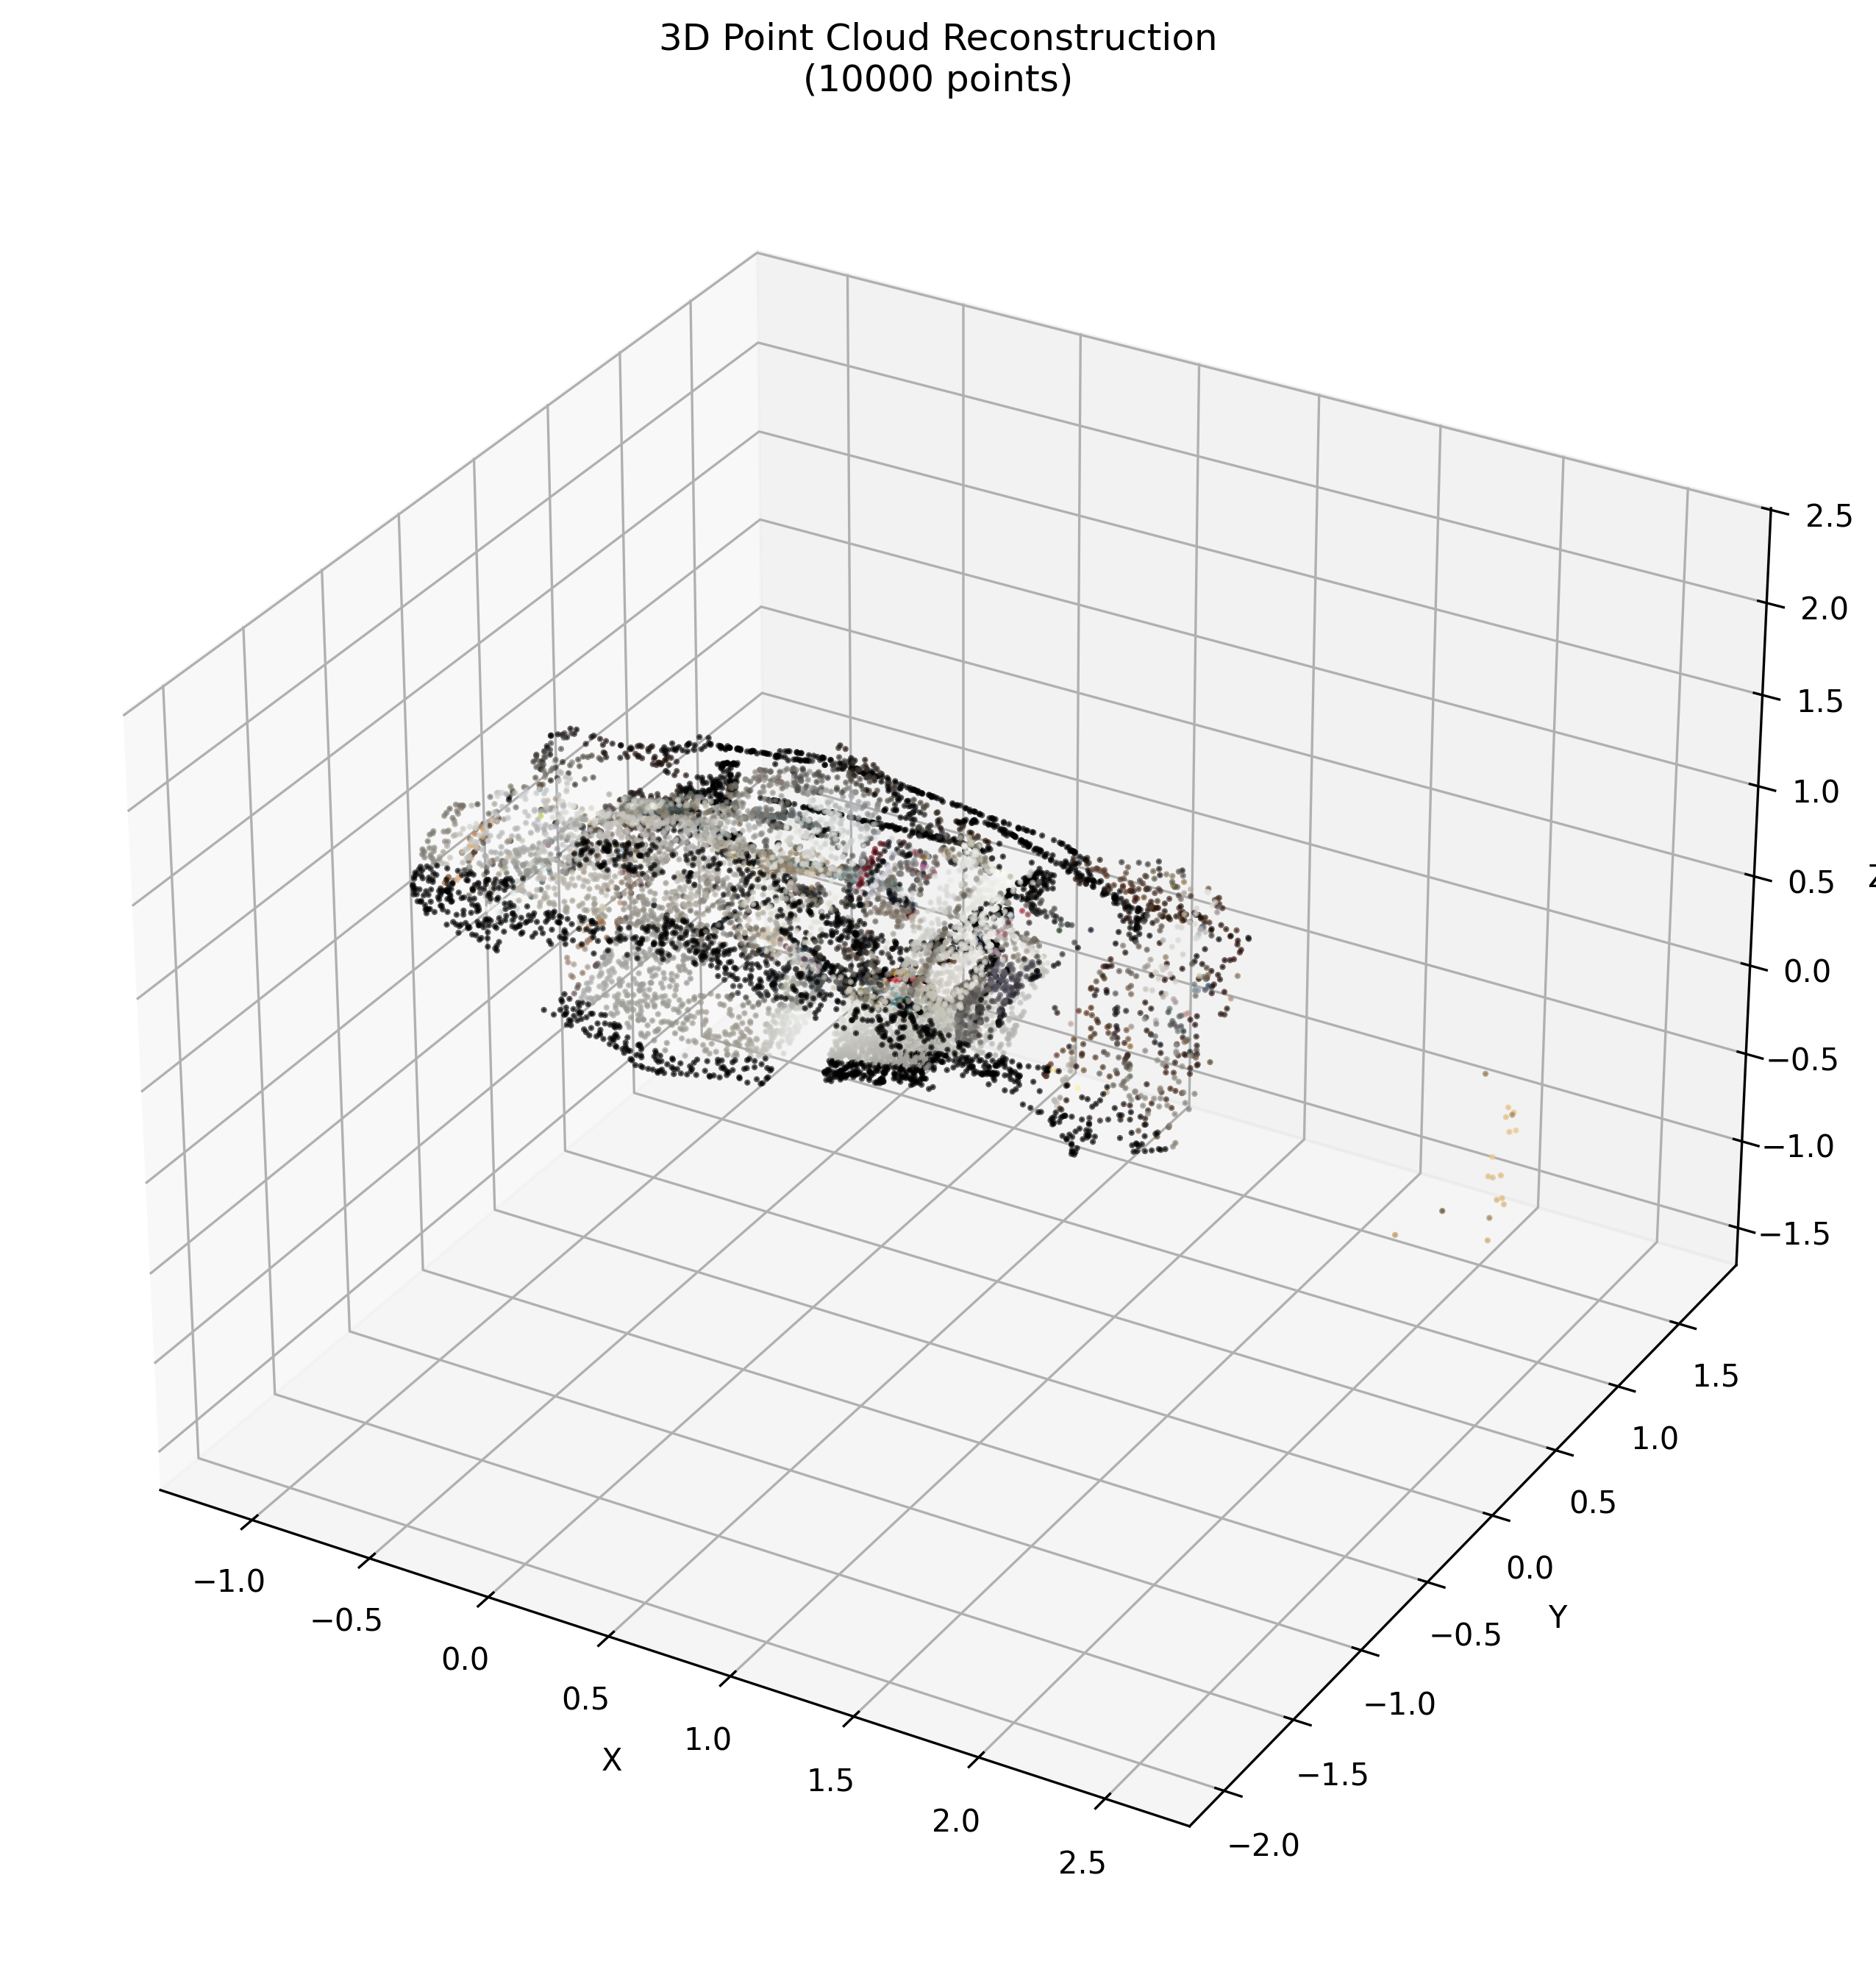

Visualized 10000 points from the 3D reconstruction


In [14]:
# Visualize 3D point cloud
if len(combined_points) > 0:
    # Subsample for visualization if too many points
    max_points = 10000
    if len(combined_points) > max_points:
        indices = np.random.choice(len(combined_points), max_points, replace=False)
        vis_points = combined_points[indices]
        vis_colors = combined_colors[indices]
    else:
        vis_points = combined_points
        vis_colors = combined_colors
    
    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points with colors
    scatter = ax.scatter(vis_points[:, 0], vis_points[:, 1], vis_points[:, 2], 
                        c=vis_colors/255.0, s=1, alpha=0.6)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'3D Point Cloud Reconstruction\n({len(vis_points)} points)')
    
    # Set equal aspect ratio
    max_range = np.array([vis_points[:, 0].max() - vis_points[:, 0].min(),
                         vis_points[:, 1].max() - vis_points[:, 1].min(),
                         vis_points[:, 2].max() - vis_points[:, 2].min()]).max() / 2.0
    
    mid_x = (vis_points[:, 0].max() + vis_points[:, 0].min()) * 0.5
    mid_y = (vis_points[:, 1].max() + vis_points[:, 1].min()) * 0.5
    mid_z = (vis_points[:, 2].max() + vis_points[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Visualized {len(vis_points)} points from the 3D reconstruction")
else:
    print("No points to visualize")

In [15]:
# Display camera poses
print("\nCamera Poses (Extrinsic Matrices):")
# Squeeze to remove batch dimension
extrinsics_viz = extrinsics.squeeze(0)
intrinsics_viz = intrinsics.squeeze(0)

for i in range(len(extrinsics_viz)):
    print(f"\nCamera {i+1}:")
    print(f"Rotation:\n{extrinsics_viz[i][:3, :3]}")
    print(f"Translation: {extrinsics_viz[i][:3, 3]}")
    
print("\nIntrinsic Parameters:")
for i in range(len(intrinsics_viz)):
    print(f"Camera {i+1}: Shape {intrinsics_viz[i].shape}")
    # Simplified display due to tensor formatting issues
    print(f"  Intrinsic matrix available")


Camera Poses (Extrinsic Matrices):

Camera 1:
Rotation:
[[ 1.00000000e+00 -2.22730851e-05 -2.46177842e-05]
 [ 2.22757426e-05  1.00000000e+00  1.07958134e-04]
 [ 2.46153813e-05 -1.07958687e-04  1.00000000e+00]]
Translation: [ 1.0171485e-04 -1.6051854e-05 -7.5070187e-05]

Camera 2:
Rotation:
[[-0.6789324  -0.44173133  0.5864506 ]
 [ 0.1534374   0.69575655  0.70169777]
 [-0.71798867  0.5663888  -0.40459347]]
Translation: [-0.05651123  0.0277617  -0.01330093]

Camera 3:
Rotation:
[[-0.93027997  0.13941033 -0.3393289 ]
 [-0.20315358  0.57442313  0.7929481 ]
 [ 0.30546355  0.8065996  -0.5060526 ]]
Translation: [0.02290996 0.04178853 0.0588292 ]

Camera 4:
Rotation:
[[ 0.3717996  -0.5416257   0.75392747]
 [ 0.36650795  0.83181614  0.41683784]
 [-0.85289913  0.12134027  0.50777906]]
Translation: [-0.14516862  0.05011993 -0.09719522]

Camera 5:
Rotation:
[[-0.47197318  0.48059443 -0.7391012 ]
 [-0.43271813  0.60413694  0.66915894]
 [ 0.76811236  0.6356474  -0.07717454]]
Translation: [ 0.050151

In [16]:
# Summary statistics
print("\n=== VGGT 3D Reconstruction Summary ===")
print(f"Scene: {scene_dir.name}")
print(f"Number of input images: {len(images)}")
print(f"Image resolution: {images.shape[-2:]}")
print(f"Total 3D points generated: {len(combined_points) if len(combined_points) > 0 else 0}")
print(f"Confidence threshold used: {confidence_threshold}")
print(f"Device used: {device}")
print(f"Data type: {dtype}")

if len(combined_points) > 0:
    print(f"\nPoint cloud statistics:")
    print(f"X range: [{combined_points[:, 0].min():.3f}, {combined_points[:, 0].max():.3f}]")
    print(f"Y range: [{combined_points[:, 1].min():.3f}, {combined_points[:, 1].max():.3f}]")
    print(f"Z range: [{combined_points[:, 2].min():.3f}, {combined_points[:, 2].max():.3f}]")


=== VGGT 3D Reconstruction Summary ===
Scene: room
Number of input images: 8
Image resolution: torch.Size([518, 518])
Total 3D points generated: 2146592
Confidence threshold used: 0.5
Device used: cpu
Data type: torch.float32

Point cloud statistics:
X range: [-1.395, 2.830]
Y range: [-1.138, 0.884]
Z range: [-0.749, 1.543]
